# Mel spectrogram study

In [3]:
import sys,os,signal

import numpy as np

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss
from torch.nn import Conv1d

from scipy import fft, fftpack
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

from librosa.feature import melspectrogram
from librosa import mel_frequencies
from librosa.core.spectrum import _spectrogram
from librosa.core import stft
from librosa.filters import mel

root = './'

%matplotlib inline

In [4]:
x = np.load("waveform_x.np.npy")

# Step by step

## Generating data

In [5]:
t = np.linspace(0,1,2048)
y1 = np.sin(2*np.pi*20*t) #+ np.random.normal(scale=1,size=20480)
y2 = np.sin(2*np.pi*200*t)
y = np.concatenate((y1, y2))

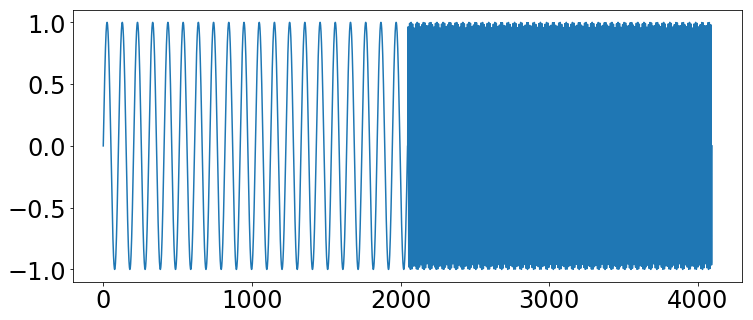

In [6]:
plt.figure(figsize=(12,5))
plt.plot(y)
plt.tick_params("both",labelsize=24)

## Method 1

In [7]:
Fourier_output = fft(y1, n=2048) # Center = True

In [8]:
Magnitude = np.abs(Fourier_output)

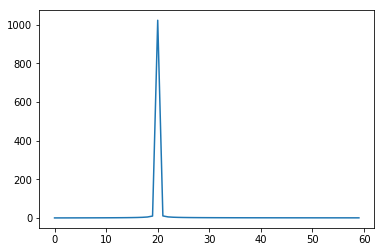

In [9]:
plt.plot(Magnitude[:60])

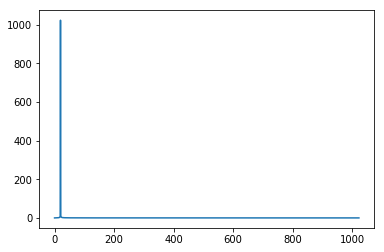

In [10]:
plt.plot(Magnitude[:1024])

## Step by Step from FFT (Pytorch version)

In [11]:
stride = 512

In [12]:
from scipy.signal.windows import hann

In [13]:
def create_filters(window_size,low=50,high=6000):
    s = np.arange(0, window_size, 1)
    wsin = np.empty((window_size,1,window_size), dtype=np.float32)
    wcos = np.empty((window_size,1,window_size), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    # window_mask = hann(2048, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    for ind in range(window_size):
        wsin[ind,0,:] = np.sin(2*np.pi*ind*s/window_size)
        wcos[ind,0,:] = np.cos(2*np.pi*ind*s/window_size)
    
    return wsin,wcos

Text(0.5, 0, 'num of samples')

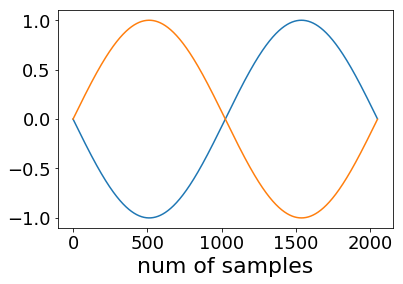

In [15]:
window_size = 2048
s = np.arange(0, window_size, 1)
ind1 = 2047
ind2 = 1

plt.plot(np.sin(2*np.pi*ind1*s/window_size))
plt.plot(np.sin(2*np.pi*ind2*s/window_size))
plt.tick_params("both", labelsize=18)
plt.xlabel('num of samples', size=22)

In [17]:
wsin, wcos = create_filters(2048)

In [18]:
wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)

In [19]:
network_input = torch.from_numpy(y)

In [20]:
network_input = network_input.reshape(1,-1).float()

In [21]:
network_input.shape

torch.Size([1, 4096])

In [22]:
zx = np.sqrt(conv1d(network_input[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(network_input[:,None,:], wcos_var, stride=stride).pow(2))

In [23]:
wcos.shape

(2048, 1, 2048)

In [24]:
wcos[0][0].shape

(2048,)

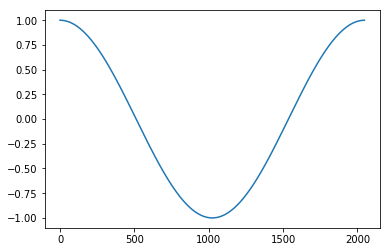

In [25]:
plt.plot(wcos[1,0])

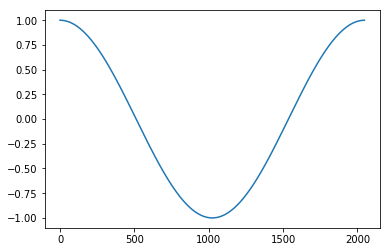

In [26]:
plt.plot(wcos[1,0])

In [27]:
t = np.linspace(0,1,2048)
y2 = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*20*t)

([], <a list of 0 Text xticklabel objects>)

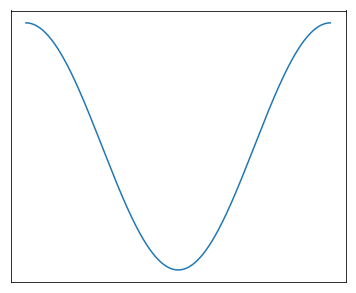

In [28]:
plt.figure(figsize=(6,5))
plt.plot(wcos[-1,0])
plt.yticks([])
plt.xticks([])

In [29]:
np.dot(y2, wcos[1,0])

0.00010744284302552365

In [30]:
conv1d(network_input[:,None,:], wsin_var, stride=stride).shape

torch.Size([1, 2048, 5])

In [31]:
pytorch_Xs = zx.cpu().numpy()

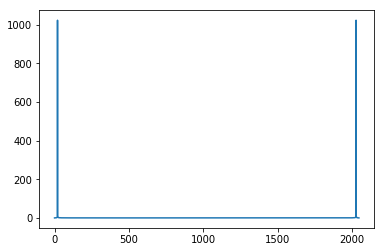

In [37]:
plt.plot(pytorch_Xs[0,:,0])

In [32]:
np.allclose(Magnitude[:1024], pytorch_Xs[0,0:1024,0],atol=1e-5)

False

## Step by Step from FFT (Pytorch Conv1d version)

In [33]:
cosConv = Conv1d(in_channels=1,out_channels=2048,kernel_size=2048, stride=stride, padding=0, bias=False)
sinConv = Conv1d(in_channels=1,out_channels=2048,kernel_size=2048, stride=stride, padding=0, bias=False)

In [34]:
sinConv.weight.data = wsin_var
sinout = sinConv(network_input[:,None,:])

In [35]:
sinout.shape

torch.Size([1, 2048, 5])

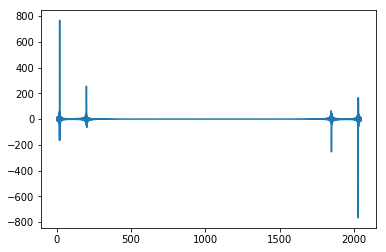

In [36]:
plt.plot(sinout.cpu().detach().numpy()[0,:,1])

# Compare output

In [37]:
original_sin = conv1d(network_input[:,None,:], wsin_var, stride=stride)

In [38]:
original_sin.shape

torch.Size([1, 2048, 5])

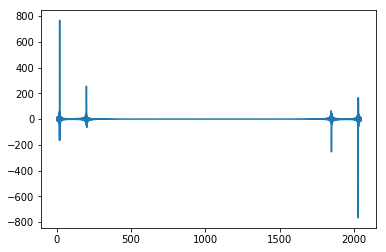

In [39]:
plt.plot(original_sin.cpu().numpy()[0,:,1])

In [40]:
np.allclose(sinout.detach(), original_sin)

True